# Files

- train_audio/ The training data consists of short recordings of individual bird, amphibian, mammal and insects sounds generously uploaded by users of xeno-canto.org, iNaturalist and the Colombian Sound Archive (CSA) of the Humboldt Institute for Biological Resources Research in Colombia. These files have been resampled to 32 kHz where applicable to match the test set audio and converted to the ogg format. Filenames consist of [collection][file_id_in_collection].ogg. The training data should have nearly all relevant files; we expect there is no benefit to looking for more on xeno-canto.org or iNaturalist and appreciate your cooperation in limiting the burden on their servers. If you do, please make sure to adhere to the scraping rules of these data portals.

- test_soundscapes/ When you submit a notebook, the test_soundscapes directory will be populated with approximately 700 recordings to be used for scoring. They are 1 minute long and in ogg audio format, resampled to 32 kHz. The file names are randomized, but have the general form of soundscape_xxxxxx.ogg. It should take your submission notebook approximately five minutes to load all the test soundscapes. Not all species from the train data actually occur in the test data.

- train_soundscapes/ Unlabeled audio data from the same recording locations as the test soundscapes. Filenames consist of [site]_[date]_[local_time].ogg; although recorded at the same location, precise recording sites of unlabeled soundscapes do NOT overlap with recording sites of the hidden test data.

- train.csv A wide range of metadata is provided for the training data. The most directly relevant fields are:

- primary_label: A code for the species (eBird code for birds, iNaturalist taxon ID for non-birds). You can review detailed information about the species by appending codes to eBird and iNaturalis taxon URL, such as https://ebird.org/species/gretin1 for the Great Tinamou or https://www.inaturalist.org/taxa/24322 for the Red Snouted Tree Frog. Not all species have their own pages; some links might fail.
- secondary_labels: List of species labels that have been marked by recordists to also occur in the recording. Can be incomplete.
- latitude & longitude: Coordinates for where the recording was taken. Some bird species may have local call 'dialects,' so you may want to seek geographic diversity in your training data.
- author: The user who provided the recording. Unknown if no name was provided.
- filename: The name of the associated audio file.
- rating: Values in 1..5 (1 - low quality, 5 - high quality) provided by users of Xeno-canto; 0 implies no rating is available; iNaturalist and the CSA do not provide quality ratings.
- collection: Either XC, iNat or CSA, indicating which collection the recording was taken from. Filenames also reference the collection and the ID within that collection.
- sample_submission.csv A valid sample submission.

- row_id: A slug of soundscape_[soundscape_id]_[end_time] for the prediction; e.g., Segment 00:15-00:20 of 1-minute test soundscape soundscape_12345.ogg has row ID soundscape_12345_20.
- [species_id]: There are 206 species ID columns. You will need to predict the probability of the presence of each species for each row.
- taxonomy.csv - Data on the different species, including iNaturalist taxon ID and class name (Aves, Amphibia, Mammalia, Insecta).

- recording_location.txt - Some high-level information on the recording location (El Silencio Natural Reserve).

In [4]:
# %pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu126

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import torch
import torchaudio
import torch.nn.functional as F
from tqdm import tqdm



In [6]:
torch.cuda.is_available()

True

In [7]:
train = pd.read_csv(r"data\train.csv")
taxonomy = pd.read_csv(r"data\taxonomy.csv") 
sample_submission = pd.read_csv(r"data\sample_submission.csv")

In [8]:
# Display basic information
print(f"Training data shape: {train.shape}")
print(f"Taxonomy data shape: {taxonomy.shape}")
print(f"Sample submission shape: {sample_submission.shape}")

# Display the first few rows of each dataframe
print("\nTraining data sample:")
display(train.head())

print("\nTaxonomy data sample:")
display(taxonomy.head())

print("\nSample submission format:")
display(sample_submission.head(3))

Training data shape: (28564, 13)
Taxonomy data shape: (206, 5)
Sample submission shape: (3, 207)

Training data sample:


primary_label secondary_labels  type              filename collection  \
0       1139490             ['']  ['']  1139490/CSA36385.ogg        CSA   
1       1139490             ['']  ['']  1139490/CSA36389.ogg        CSA   
2       1192948             ['']  ['']  1192948/CSA36358.ogg        CSA   
3       1192948             ['']  ['']  1192948/CSA36366.ogg        CSA   
4       1192948             ['']  ['']  1192948/CSA36373.ogg        CSA   

   rating                                                url  latitude  \
0     0.0  http://colecciones.humboldt.org.co/rec/sonidos...    7.3206   
1     0.0  http://colecciones.humboldt.org.co/rec/sonidos...    7.3206   
2     0.0  http://colecciones.humboldt.org.co/rec/sonidos...    7.3791   
3     0.0  http://colecciones.humboldt.org.co/rec/sonidos...    7.2800   
4     0.0  http://colecciones.humboldt.org.co/rec/sonidos...    7.3791   

   longitude        scientific_name            common_name             author  \
0   -73.7128   Ragoniella pulchella   Ragoniella pulchella  Fabio A. Sarria-S   
1   -73.7128   Ragoniella pulchella   Ragoniella pulchella  Fabio A. Sarria-S   
2   -73.7313  Oxyprora surinamensis  Oxyprora surinamensis  Fabio A. Sarria-S   
3   -73.8582  Oxyprora surinamensis  Oxyprora surinamensis  Fabio A. Sarria-S   
4   -73.7313  Oxyprora surinamensis  Oxyprora surinamensis  Fabio A. Sarria-S   

           license  
0  cc-by-nc-sa 4.0  
1  cc-by-nc-sa 4.0  
2  cc-by-nc-sa 4.0  
3  cc-by-nc-sa 4.0  
4  cc-by-nc-sa 4.0


Taxonomy data sample:


primary_label  inat_taxon_id               scientific_name  \
0       1139490        1139490          Ragoniella pulchella   
1       1192948        1192948         Oxyprora surinamensis   
2       1194042        1194042           Copiphora colombiae   
3        126247         126247       Leptodactylus insularum   
4       1346504        1346504  Neoconocephalus brachypterus   

                    common_name class_name  
0          Ragoniella pulchella    Insecta  
1         Oxyprora surinamensis    Insecta  
2           Copiphora colombiae    Insecta  
3        Spotted Foam-nest Frog   Amphibia  
4  Neoconocephalus brachypterus    Insecta


Sample submission format:


row_id   1139490   1192948   1194042    126247   1346504  \
0   soundscape_8358733_5  0.004854  0.004854  0.004854  0.004854  0.004854   
1  soundscape_8358733_10  0.004854  0.004854  0.004854  0.004854  0.004854   
2  soundscape_8358733_15  0.004854  0.004854  0.004854  0.004854  0.004854   

     134933    135045   1462711   1462737  ...   yebfly1   yebsee1   yecspi2  \
0  0.004854  0.004854  0.004854  0.004854  ...  0.004854  0.004854  0.004854   
1  0.004854  0.004854  0.004854  0.004854  ...  0.004854  0.004854  0.004854   
2  0.004854  0.004854  0.004854  0.004854  ...  0.004854  0.004854  0.004854   

    yectyr1   yehbla2   yehcar1   yelori1   yeofly1   yercac1    ywcpar  
0  0.004854  0.004854  0.004854  0.004854  0.004854  0.004854  0.004854  
1  0.004854  0.004854  0.004854  0.004854  0.004854  0.004854  0.004854  
2  0.004854  0.004854  0.004854  0.004854  0.004854  0.004854  0.004854  

[3 rows x 207 columns]

In [9]:
def load_and_visualize_audio(filename, base_path="data/train_audio"):
    """Load audio file and visualize its waveform and spectrogram"""
    # Construct full file path
    file_path = os.path.join(base_path, filename)
    
    # Load audio using torchaudio
    waveform, sample_rate = torchaudio.load(file_path)
    waveform = waveform[0].numpy()  # Get first channel
    
    # Create figure with 2 subplots
    fig, ax = plt.subplots(2, 1, figsize=(12, 8))
    
    # Plot waveform
    ax[0].plot(waveform)
    ax[0].set_title(f"Waveform - {os.path.basename(filename)}")
    ax[0].set_xlabel("Sample")
    ax[0].set_ylabel("Amplitude")
    
    # Plot spectrogram using torchaudio
    spectrogram = torchaudio.transforms.Spectrogram()(torch.tensor([waveform]))
    spec_db = 20 * torch.log10(spectrogram + 1e-5)
    ax[1].imshow(spec_db[0].numpy(), aspect='auto', origin='lower')
    ax[1].set_title(f"Spectrogram - {os.path.basename(filename)}")
    ax[1].set_xlabel("Time")
    ax[1].set_ylabel("Frequency")
    
    plt.tight_layout()
    plt.show()
    
    return sample_rate

C:\Users\ricar\AppData\Local\Temp\ipykernel_9584\2616936034.py:20: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  spectrogram = torchaudio.transforms.Spectrogram()(torch.tensor([waveform]))


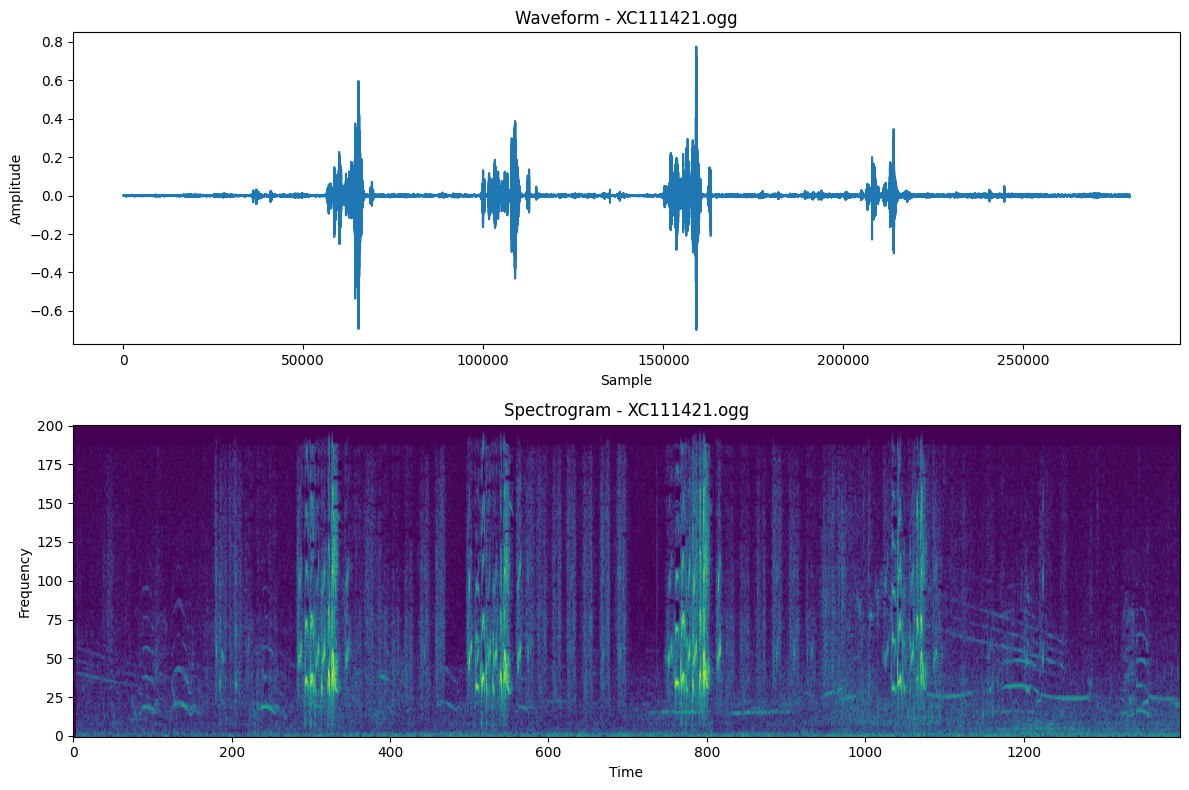

Sample Rate: 32000 Hz
Species: White-headed Marsh Tyrant (Arundinicola leucocephala)
Class: Aves



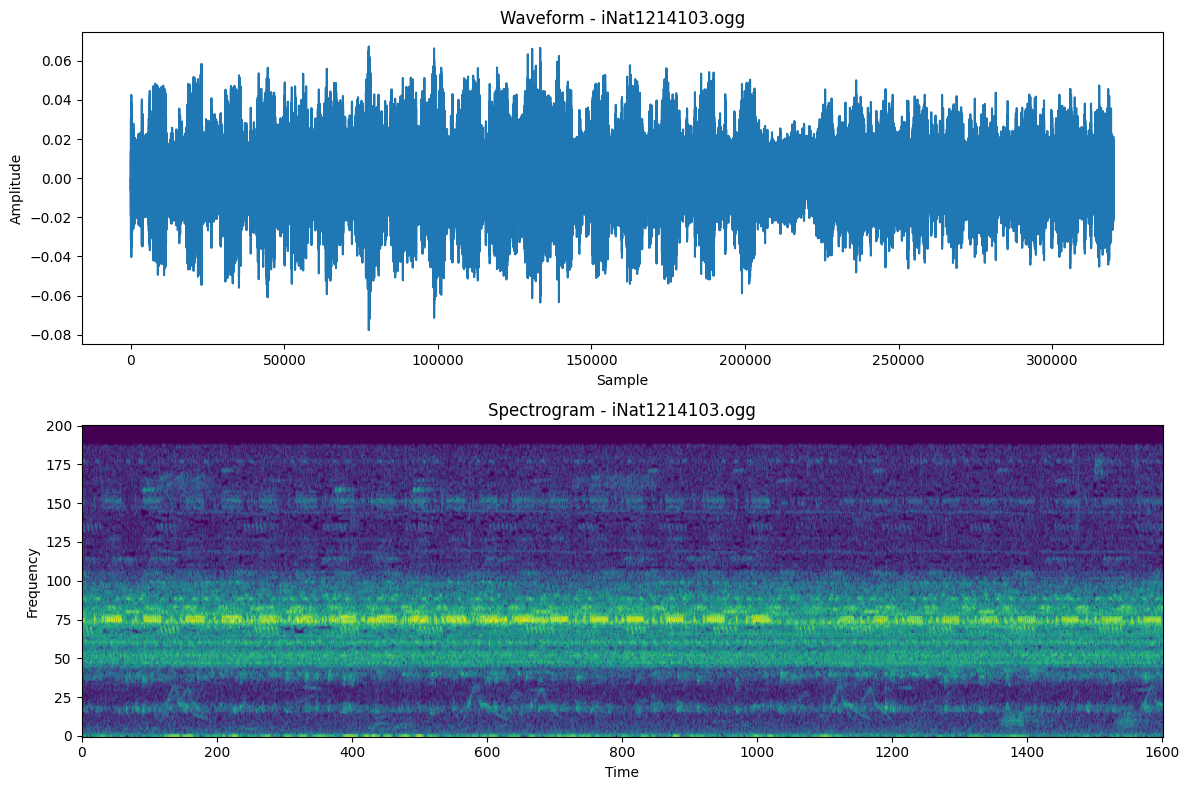

Sample Rate: 32000 Hz
Species: Great Potoo (Nyctibius grandis)
Class: Aves



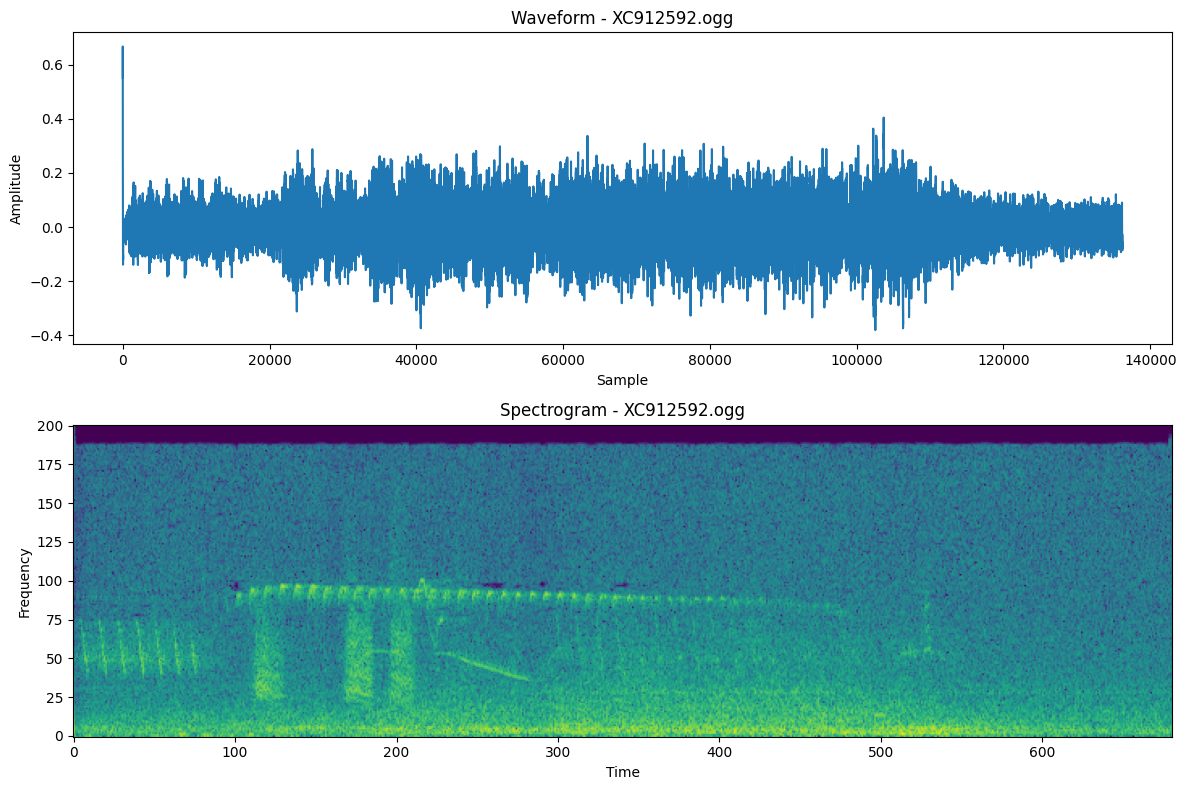

Sample Rate: 32000 Hz
Species: Olivaceous Piculet (Picumnus olivaceus)
Class: Aves



In [10]:
# Select 3 random examples from different species (ensure they're different by getting unique primary_labels)
unique_species = train['primary_label'].unique()
selected_species = np.random.choice(unique_species, size=min(3, len(unique_species)), replace=False)
sample_files = []

for species in selected_species:
    species_samples = train[train['primary_label'] == species]
    if not species_samples.empty:
        sample_files.append(species_samples.sample(1)['filename'].values[0])

# Visualize the samples
for file in sample_files:
    try:
        sample_rate = load_and_visualize_audio(file)
        # Print metadata for this sample
        sample_info = train[train['filename'] == file].iloc[0]
        species_info = taxonomy[taxonomy['primary_label'] == sample_info['primary_label']].iloc[0]
        print(f"Sample Rate: {sample_rate} Hz")
        print(f"Species: {species_info['common_name']} ({species_info['scientific_name']})")
        print(f"Class: {species_info['class_name']}\n")
    except Exception as e:
        print(f"Error loading {file}: {e}")

In [11]:
def plot_mel_spectrogram(filename, mel_params=None, target_shape=(256, 256), base_path="data/train_audio"):
    """
    Plot a mel spectrogram for an audio file
    
    Parameters:
    -----------
    filename : str
        Path to the audio file relative to base_path
    mel_params : dict, optional
        Dictionary of parameters for MelSpectrogram transformation
        Common parameters include: n_fft, hop_length, n_mels, f_min, f_max
    base_path : str, optional
        Base directory for audio files
    target_shape : tuple, optional
        Target shape to resize the spectrogram to, as (height, width)
        Default is (256, 256)
        
    Returns:
    --------
    mel_spec_db : torch.Tensor
        The computed mel spectrogram in dB scale, resized to target_shape if specified.
        Shape will be [channels, height, width] where channels is typically 1.
    """
    # 1. Load audio file
    waveform, sample_rate = torchaudio.load(os.path.join(base_path, filename))
    
    # 2. Set default parameters if not provided
    default_params = {
        'sample_rate': 32000,
        'n_fft': 1034,
        'hop_length': 64,
        'n_mels': 136,
        'f_min': 20,
        'f_max': 16000
    }
    
    # Update defaults with user-provided parameters
    if mel_params is not None:
        default_params.update(mel_params)
    
    # Create mel spectrogram
    mel_transform = torchaudio.transforms.MelSpectrogram(**default_params)

    mel_spec = mel_transform(waveform).unsqueeze(0)

    if mel_spec.shape[-2:] != target_shape:
        mel_spec = F.interpolate(mel_spec, size=target_shape, mode='bilinear', align_corners=False).squeeze(0)

    mel_spec_db = torchaudio.transforms.AmplitudeToDB()(mel_spec)
        
    # 5. Plot the mel spectrogram
    plt.figure(figsize=(12, 5))
    plt.imshow(mel_spec_db[0].numpy(), aspect='auto', origin='lower')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Mel Spectrogram - {os.path.basename(filename)}')
    plt.xlabel('Time Frames')
    plt.ylabel('Mel Frequency Bins')
    plt.tight_layout()
    plt.show()

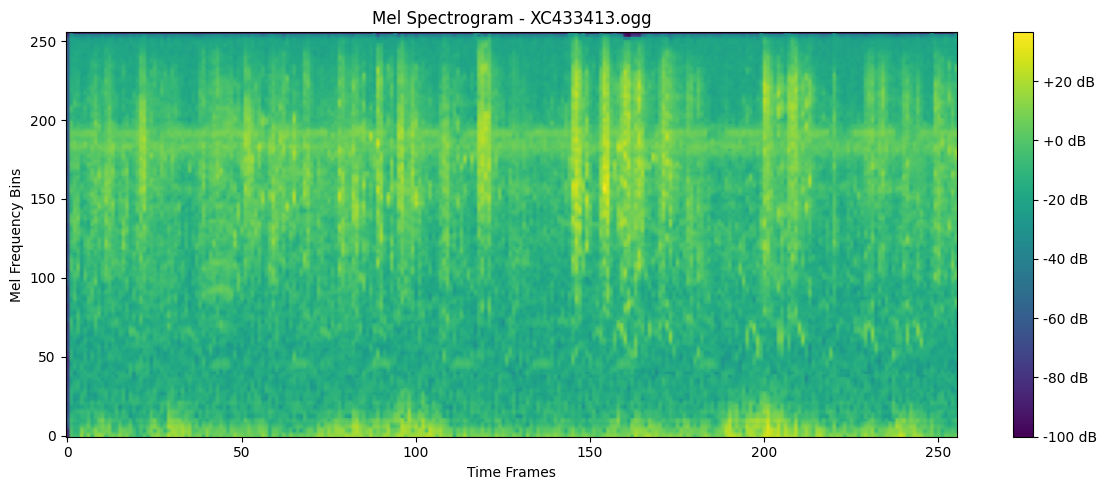

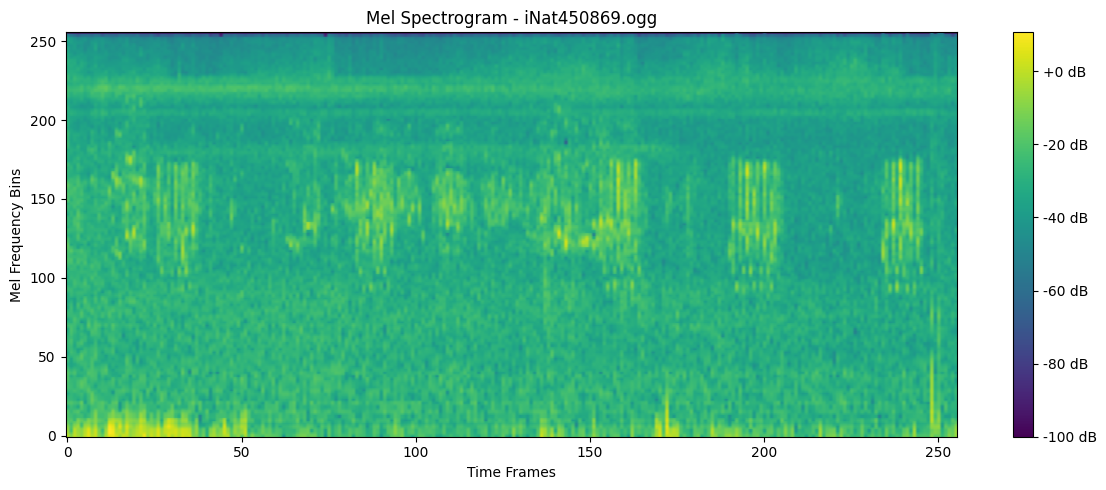

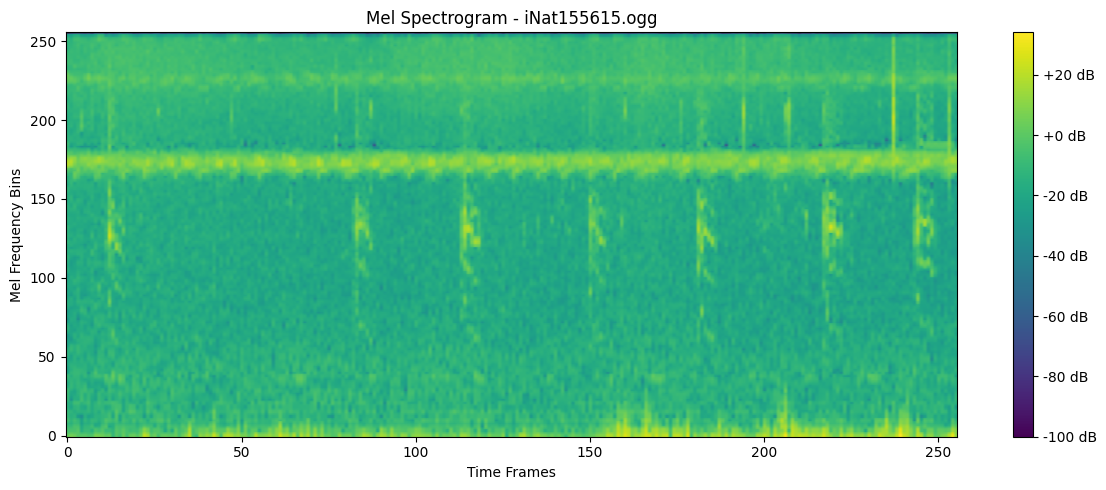

In [12]:
# Using custom parameters
custom_params = {
    'sample_rate': 32000,
    'n_fft': 1034,
    'hop_length': 64,
    'n_mels': 136,
    'f_min': 20,
    'f_max': 16000
}

file_names = np.random.choice(train['filename'], size=min(3, len(train['filename'])), replace=False)
for file_name in file_names:
    plot_mel_spectrogram(file_name, mel_params=custom_params, target_shape=(256, 256))

In [16]:
def create_mel_spectrograms_dataset(file_list, mel_params=None, target_shape=(256, 256), base_path="data/train_audio"):
    """
    Process a list of audio files and convert them to mel spectrograms
    
    Parameters:
    -----------
    file_list : list
        List of audio file paths relative to base_path
    mel_params : dict, optional
        Dictionary of parameters for MelSpectrogram transformation
    target_shape : tuple, optional
        Target shape to resize the spectrograms to (height, width)
    base_path : str, optional
        Base directory for audio files
        
    Returns:
    --------
    spectrograms : dict
        Dictionary mapping filenames to their mel spectrograms
    """
        # Check if GPU is available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Set default parameters if not provided
    default_params = {
        'sample_rate': 32000,
        'n_fft': 1034,
        'hop_length': 64,
        'n_mels': 136,
        'f_min': 20,
        'f_max': 16000
    }
    
    # Update defaults with user-provided parameters
    if mel_params is not None:
        default_params.update(mel_params)
    
    # Create the mel spectrogram transform
    mel_transform = torchaudio.transforms.MelSpectrogram(**default_params).to(device)
    to_db = torchaudio.transforms.AmplitudeToDB().to(device)
    
    # Dictionary to store results
    spectrograms = {}
    
    # Process each file with progress bar
    for filename in tqdm(file_list, desc="Processing audio files"):
        try:
            # Load audio
            waveform, sample_rate = torchaudio.load(os.path.join(base_path, filename))
            
            # Move to GPU
            waveform = waveform.to(device)

            # Create mel spectrogram
            mel_spec = mel_transform(waveform).unsqueeze(0)
            
            # Resize if needed
            if mel_spec.shape[-2:] != target_shape:
                mel_spec = F.interpolate(mel_spec, size=target_shape, mode='bilinear', align_corners=False).squeeze(0)
            
            # Convert to dB
            mel_spec_db = to_db(mel_spec)
            
            # Store in dictionary
            spectrograms[filename] = mel_spec_db
                
        except Exception as e:
            print(f"Error processing {filename}: {e}")
    
    return spectrograms

# Example usage:
# Get list of all audio files from the training dataset
audio_files = train['filename'].tolist()

# Process all files (or a subset for testing)
mel_specs = create_mel_spectrograms_dataset(audio_files[:10])  # Process just 10 files for testing
# mel_specs = create_mel_spectrograms_dataset(audio_files)  # Process all files

Using device: cuda


Processing audio files: 100%|██████████| 10/10 [00:02<00:00,  3.52it/s]


In [17]:
mel_specs

{'1139490/CSA36385.ogg': tensor([[[-100.0000, -100.0000, -100.0000,  ...,   10.0798,   -5.9252,
             18.5744],
          [-100.0000, -100.0000, -100.0000,  ...,   10.5829,    2.3371,
             19.6651],
          [-100.0000, -100.0000, -100.0000,  ...,   11.3593,    6.3553,
             21.1184],
          ...,
          [ -78.8460,  -71.2321,  -73.5934,  ...,  -56.0174,  -14.2522,
            -47.7102],
          [ -83.3013,  -75.6874,  -78.0487,  ...,  -60.4727,  -18.7074,
            -52.1654],
          [-100.0000, -100.0000, -100.0000,  ..., -100.0000,  -82.7594,
           -100.0000]]], device='cuda:0'),
 '1139490/CSA36389.ogg': tensor([[[-100.0000, -100.0000, -100.0000,  ...,   -0.7730,    8.9115,
             15.0541],
          [-100.0000, -100.0000, -100.0000,  ...,   -0.3709,    7.8415,
             16.7857],
          [-100.0000, -100.0000, -100.0000,  ...,    0.2670,    4.8319,
             18.7953],
          ...,
          [ -69.8948,  -68.1904,  -70.3725,  ..